In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('data/PJME_hourly.csv')

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

df = df.set_index('Datetime').sort_index() # sắp xếp theo thời gian để chuẩn hóa dữ liệu
df = df.resample('h').mean() # ấy trung bình nếu có nhiều điểm trong cùng 1 giờ

df['PJME_MW'] = df['PJME_MW'].interpolate(method='time') # nội suy giá trị thiếu theo thời gian

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145392 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


Epoch 1/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 166s 23ms/step - loss: 0.0061 - val_loss: 1.1865e-04
Epoch 2/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 208s 29ms/step - loss: 2.4543e-04 - val_loss: 5.6267e-05
Epoch 3/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 241s 33ms/step - loss: 1.4685e-04 - val_loss: 4.5468e-05
Epoch 4/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 265s 36ms/step - loss: 1.1697e-04 - val_loss: 6.1574e-05
Epoch 5/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 280s 38ms/step - loss: 1.0502e-04 - val_loss: 5.0559e-05
Epoch 6/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 276s 38ms/step - loss: 9.5214e-05 - val_loss: 5.4889e-05
Epoch 7/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 3339s 459ms/step - loss: 9.1606e-05 - val_loss: 3.2229e-05
Epoch 8/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 845s 116ms/step - loss: 8.7622e-05 - val_loss: 6.8637e-05
Epoch 9/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 257s 35ms/step - loss: 8.5261e-05 - val_loss: 3.5571e-05
Epoch 10/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 247s 34ms/step - loss: 8.0824e-05 - val_loss: 3.0615e-05
Epoch 11/5

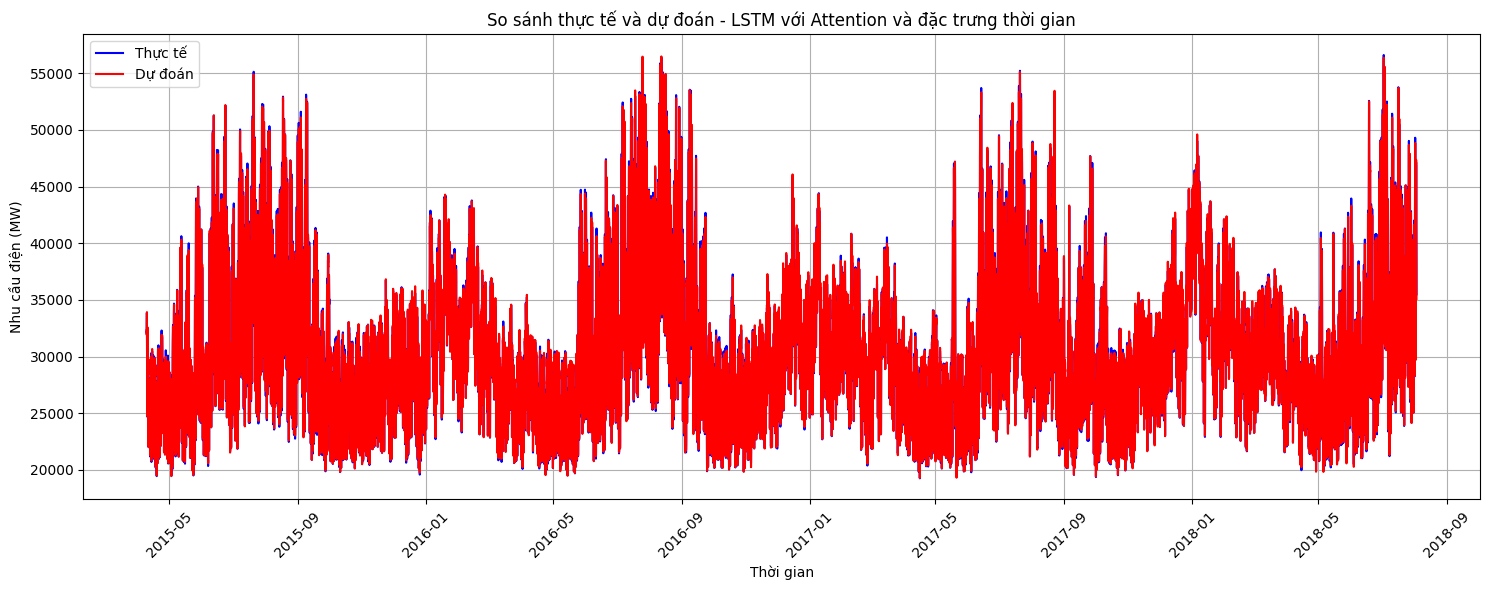

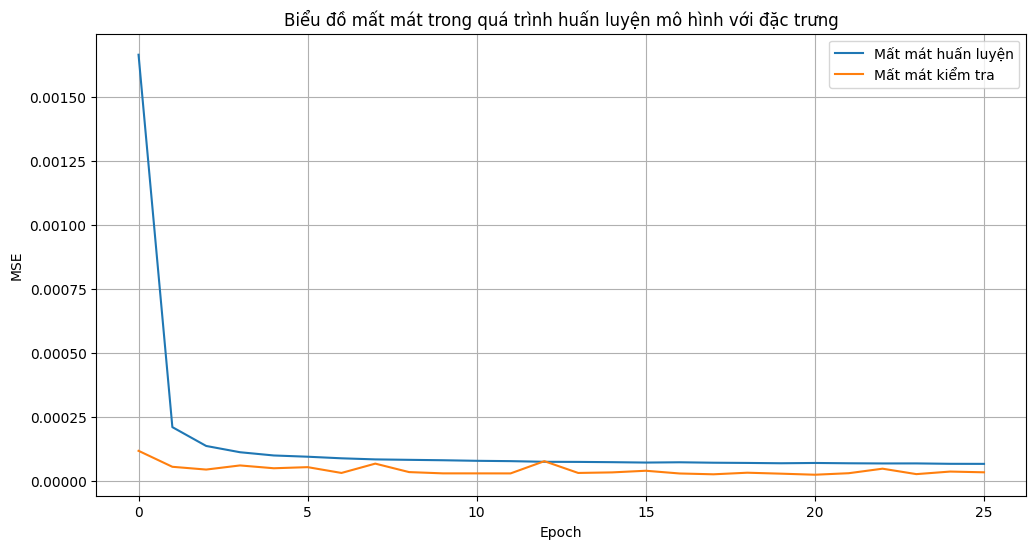

In [5]:
df_features = df.copy()
df_features['hour'] = df.index.hour
df_features['day'] = df.index.day  
df_features['month'] = df.index.month
df_features['season'] = ((df.index.month % 12) // 3).map({0: 0, 1: 1, 2: 2, 3: 3})  # 0:Đông, 1:Xuân, 2:Hè, 3:Thu

# CREATE FEATURE
def feature_engineering(df):
    df = df.copy()
    
    # TRỄ
    for lag in [1, 24, 168]:
        df[f'lag_{lag}h'] = df['PJME_MW'].shift(lag)
    
    # TRƯỢT
    for window in [24]:
        df[f'rolling_mean_{window}h'] = df['PJME_MW'].rolling(window=window).mean()
        df[f'rolling_std_{window}h'] = df['PJME_MW'].rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df['PJME_MW'].rolling(window=window).min()
        df[f'rolling_max_{window}h'] = df['PJME_MW'].rolling(window=window).max()
    
    return df

def fillna(df):
    df = df.copy()
    
    for col in df.columns:
        if col.startswith('lag_'):
            df[col] = df.groupby(df.index.hour)[col].transform(lambda x: x.fillna(x.mean()))
    
    for window in [24]:
        mask = df[f'rolling_mean_{window}h'].isna()
        df.loc[mask, f'rolling_mean_{window}h'] = df.loc[mask, 'PJME_MW']
        df[f'rolling_std_{window}h'] = df[f'rolling_std_{window}h'].fillna(0)
        df.loc[mask, f'rolling_min_{window}h'] = df.loc[mask, 'PJME_MW']
        df.loc[mask, f'rolling_max_{window}h'] = df.loc[mask, 'PJME_MW']
    
    return df

df_features = feature_engineering(df_features)
df_features = fillna(df_features)

# 3. Chuẩn hóa dữ liệu
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

# Chuẩn hóa biến mục tiêu
scaled_target = scaler_target.fit_transform(df_features[['PJME_MW']])

# Chuẩn hóa các đặc trưng
features = [
    'hour', 'day', 'month', 'season',
    
    # Lag features
    'lag_1h', 'lag_24h', 'lag_168h',
    
    # Rolling statistics
    'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
]
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(df_features[features])

data = np.hstack((scaled_target, scaled_features))

def create_sequences_with_features(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0]) 
    return np.array(X), np.array(y)

seq_length = 24  # 24 giờ gần nhất dự đoán giờ tiếp theo
X_with_features, y_with_features = create_sequences_with_features(data, seq_length)

# 5. Tách train/test
train_size = int(len(X_with_features) * 0.8)
X_train_features = X_with_features[:train_size]
X_test_features = X_with_features[train_size:]
y_train_features = y_with_features[:train_size]
y_test_features = y_with_features[train_size:]

# Sử dụng attention + lstm 
inputs = Input(shape=(seq_length, X_with_features.shape[2]))  

lstm_out = LSTM(128, activation='tanh', return_sequences=True)(inputs)
lstm_out = LayerNormalization()(lstm_out)

attention = MultiHeadAttention(num_heads=4, key_dim=25)(lstm_out, lstm_out)
attention = LayerNormalization()(attention + lstm_out)  # Skip connection

lstm_out2 = LSTM(64, activation='tanh')(attention)
lstm_out2 = Dropout(0.1)(lstm_out2)

output = Dense(32, activation='relu')(lstm_out2)
outputs = Dense(1)(lstm_out2)

model_with_features = Model(inputs=inputs, outputs=outputs)
model_with_features.compile(optimizer='adam', loss='mse')

# HUẤN LUYỆN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_with_features = model_with_features.fit(
    X_train_features, y_train_features,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_features, y_test_features),
    callbacks=[early_stop],
    verbose=1
)

# DỰ BÁO
y_pred_features = model_with_features.predict(X_test_features, verbose=0)

y_test_features_inv = scaler_target.inverse_transform(y_test_features.reshape(-1, 1))
y_pred_features_inv = scaler_target.inverse_transform(y_pred_features)

# ĐÁNH GIÁ 
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae_features = mean_absolute_error(y_test_features_inv, y_pred_features_inv)
rmse_features = np.sqrt(mean_squared_error(y_test_features_inv, y_pred_features_inv))
mape_features = np.mean(np.abs((y_test_features_inv - y_pred_features_inv) / y_test_features_inv)) * 100

print(f"Kết quả đánh giá mô hình LSTM với Attention và đặc trưng thời gian:")
print(f"MAE: {mae_features:.2f} MW")
print(f"RMSE: {rmse_features:.2f} MW") 
print(f"MAPE: {mape_features:.2f}%")

test_dates_features = df.index[train_size + seq_length:]

plt.figure(figsize=(15, 6))
plt.plot(test_dates_features, y_test_features_inv, label='Thực tế', color='blue')
plt.plot(test_dates_features, y_pred_features_inv, label='Dự đoán', color='red')
plt.title('So sánh thực tế và dự đoán - LSTM với Attention và đặc trưng thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Nhu cầu điện (MW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_with_features.history['loss'], label='Mất mát huấn luyện')
plt.plot(history_with_features.history['val_loss'], label='Mất mát kiểm tra')
plt.title('Biểu đồ mất mát trong quá trình huấn luyện mô hình với đặc trưng')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

---

# Pipeline cho các region còn lại

In [8]:
import os

In [11]:
def feature_engineering_pipe(df, target_column):
    df = df.copy()
    for lag in [1, 24, 168]:
        df[f'lag_{lag}h'] = df[target_column].shift(lag)
    for window in [24]:
        df[f'rolling_mean_{window}h'] = df[target_column].rolling(window=window).mean()
        df[f'rolling_std_{window}h'] = df[target_column].rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df[target_column].rolling(window=window).min()
        df[f'rolling_max_{window}h'] = df[target_column].rolling(window=window).max()
    return df

def fillna_pipe(df):
    df = df.copy()
    for col in df.columns:
        if col.startswith('lag_'):
            df[col] = df.groupby(df.index.hour)[col].transform(lambda x: x.fillna(x.mean()))
    for window in [24]:
        mask = df[f'rolling_mean_{window}h'].isna()
        df.loc[mask, f'rolling_mean_{window}h'] = df.loc[mask, df.columns[0]]
        df[f'rolling_std_{window}h'] = df[f'rolling_std_{window}h'].fillna(0)
        df.loc[mask, f'rolling_min_{window}h'] = df.loc[mask, df.columns[0]]
        df.loc[mask, f'rolling_max_{window}h'] = df.loc[mask, df.columns[0]]
    return df

def create_sequences_with_features(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Mô hình LSTM + Attention
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    lstm_out = LayerNormalization()(lstm_out)
    attention = MultiHeadAttention(num_heads=4, key_dim=25)(lstm_out, lstm_out)
    attention = LayerNormalization()(attention + lstm_out)
    lstm_out2 = LSTM(64, activation='tanh')(attention)
    lstm_out2 = Dropout(0.1)(lstm_out2)
    outputs = Dense(32, activation='relu')(lstm_out2)
    outputs = Dense(1)(lstm_out2)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def train_pipeline(data_files, seq_length=24, epochs=50, batch_size=16):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    for file_path in data_files:
        print(f"\nProcessing file: {file_path}")

        df = pd.read_csv(file_path)
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        df = df.set_index('Datetime').sort_index()
        df = df.resample('h').mean()

        # Xác định cột MW nằm ở đâu
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        target_column = numeric_columns[0]
        print(f"Target column: {target_column}")

        df[target_column] = df[target_column].interpolate(method='time')

        df_features = df.copy()
        df_features['hour'] = df.index.hour
        df_features['day'] = df.index.day
        df_features['month'] = df.index.month
        df_features['season'] = ((df.index.month % 12) // 3).map({0: 0, 1: 1, 2: 2, 3: 3})

        df_features = feature_engineering_pipe(df_features, target_column)
        df_features = fillna_pipe(df_features)

        scaler_target = MinMaxScaler(feature_range=(0, 1))
        scaler_features = MinMaxScaler(feature_range=(0, 1))
        scaled_target = scaler_target.fit_transform(df_features[[target_column]])
        features = [
            'hour', 'day', 'month', 'season',
            'lag_1h', 'lag_24h', 'lag_168h',
            'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h'
        ]
        scaled_features = scaler_features.fit_transform(df_features[features])
        data = np.hstack((scaled_target, scaled_features))

        X, y = create_sequences_with_features(data, seq_length)

        train_size = int(len(X) * 0.8)
        val_size = int(len(X) * 0.1)
        X_train = X[:train_size]
        X_val = X[train_size:train_size+val_size]
        X_test = X[train_size+val_size:]
        y_train = y[:train_size]
        y_val = y[train_size:train_size+val_size]
        y_test = y[train_size+val_size:]
        test_dates = df.index[train_size + val_size + seq_length:]

        print(f"Kích thước tập train: {len(X_train)}")
        print(f"Kích thước tập validation: {len(X_val)}")
        print(f"Kích thước tập test: {len(X_test)}")
        print(f"Hình dạng X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"Hình dạng X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"Hình dạng X_test: {X_test.shape}, y_test: {y_test.shape}")

        print("\nTraining LSTM + Attention model...")
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_lstm_attention_model(input_shape)
        model.summary()

        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=1
        )

        y_pred = model.predict(X_test, verbose=0)
        y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler_target.inverse_transform(y_pred)

        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

        print("\nKết quả đánh giá LSTM + Attention:")
        print(f"MAE: {mae:.2f} MW")
        print(f"RMSE: {rmse:.2f} MW")
        print(f"MAPE: {mape:.2f}%")

        model.save(f"attention_model/lstm_attention_model_{os.path.basename(file_path)}.h5")

        plt.figure(figsize=(15, 6))
        plt.plot(test_dates, y_test_inv, label='Thực tế', color='blue')
        plt.plot(test_dates, y_pred_inv, label='Dự đoán', color='red')
        plt.title(f'So sánh thực tế và dự đoán - LSTM + Attention - {os.path.basename(file_path)}')
        plt.xlabel('Thời gian')
        plt.ylabel('Nhu cầu điện (MW)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Mất mát huấn luyện')
        plt.plot(history.history['val_loss'], label='Mất mát validation')
        plt.title(f'Biểu đồ mất mát - LSTM + Attention - {os.path.basename(file_path)}')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()


### PJMW


Processing file: data/PJMW_hourly.csv
Target column: PJMW_MW
Kích thước tập train: 114566
Kích thước tập validation: 14320
Kích thước tập test: 14322
Hình dạng X_train: (114566, 24, 12), y_train: (114566,)
Hình dạng X_val: (14320, 24, 12), y_val: (14320,)
Hình dạng X_test: (14322, 24, 12), y_test: (14322,)

Training LSTM + Attention model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 128)   │     72,192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_2[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 162s 22ms/step - loss: 0.0065 - val_loss: 1.4659e-04
Epoch 2/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - loss: 3.0732e-04 - val_loss: 8.6095e-05
Epoch 3/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 4171s 583ms/step - loss: 1.5909e-04 - val_loss: 8.9568e-05
Epoch 4/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 158s 22ms/step - loss: 1.2937e-04 - val_loss: 9.1195e-05
Epoch 5/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 153s 21ms/step - loss: 1.1448e-04 - val_loss: 6.0186e-05
Epoch 6/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 152s 21ms/step - loss: 1.0615e-04 - val_loss: 6.5443e-05
Epoch 7/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 139s 19ms/step - loss: 1.0171e-04 - val_loss: 5.8178e-05
Epoch 8/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - loss: 9.8557e-05 - val_loss: 5.7119e-05
Epoch 9/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 135s 19ms/step - loss: 9.7736e-05 - val_loss: 1.0364e-04
Epoch 10/50
7161/7161 ━━━━━━━━━━━━━━━━━━━━ 137s 19ms/step - loss: 9.0953e-05 - val_loss: 1.0315e-04
Epoch 11/50


Kết quả đánh giá LSTM + Attention:
MAE: 49.89 MW
RMSE: 64.53 MW
MAPE: 0.89%


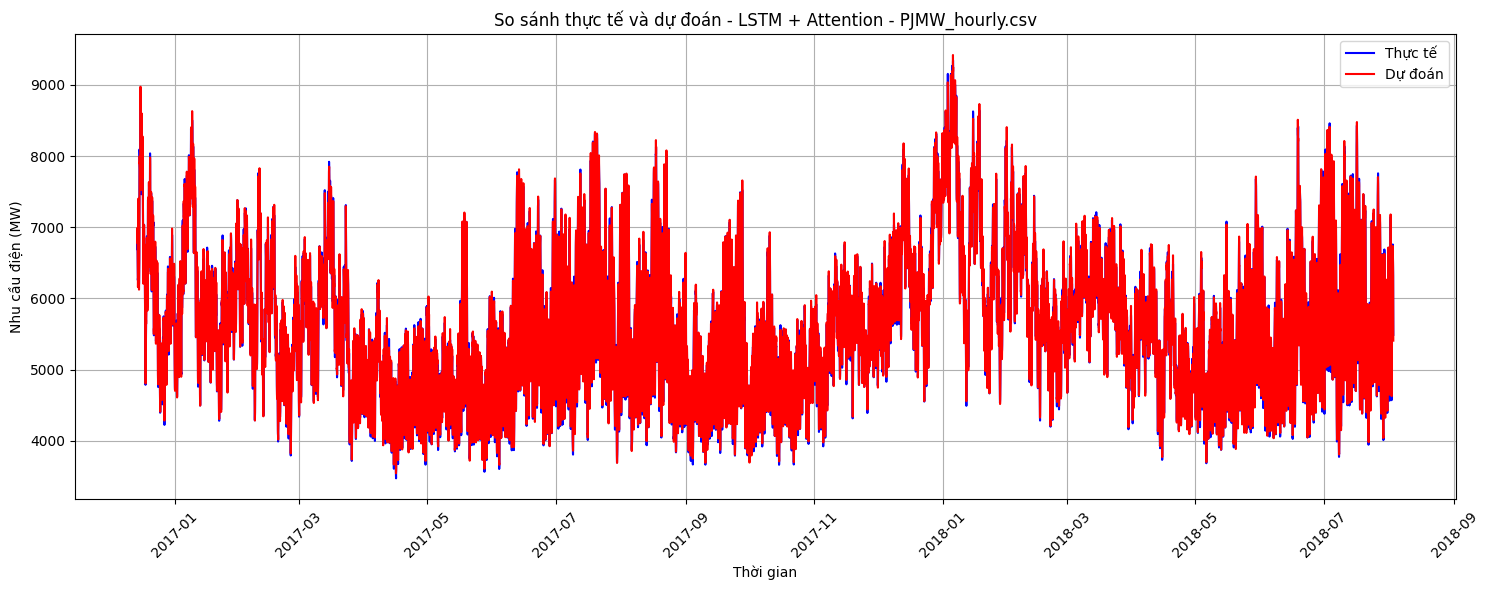

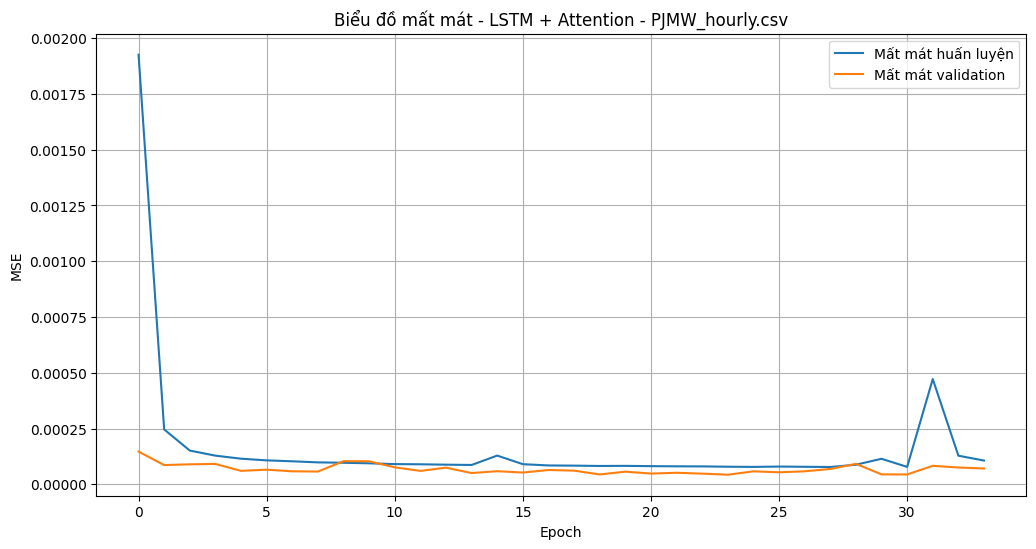

In [10]:
data_files = ['data/PJMW_hourly.csv'] 
train_pipeline(data_files, seq_length=24, epochs=50, batch_size=16)

### AEP


Processing file: data/AEP_hourly.csv
Target column: AEP_MW
Kích thước tập train: 97017
Kích thước tập validation: 12127
Kích thước tập test: 12128
Hình dạng X_train: (97017, 24, 12), y_train: (97017,)
Hình dạng X_val: (12127, 24, 12), y_val: (12127,)
Hình dạng X_test: (12128, 24, 12), y_test: (12128,)

Training LSTM + Attention model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 24, 128)   │     72,192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_4[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 133s 21ms/step - loss: 0.0052 - val_loss: 2.7784e-04
Epoch 2/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 130s 21ms/step - loss: 4.7687e-04 - val_loss: 1.7563e-04
Epoch 3/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 134s 22ms/step - loss: 2.9238e-04 - val_loss: 1.5652e-04
Epoch 4/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 122s 20ms/step - loss: 2.3071e-04 - val_loss: 1.4204e-04
Epoch 5/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 132s 22ms/step - loss: 2.1837e-04 - val_loss: 1.2008e-04
Epoch 6/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 121s 20ms/step - loss: 1.9067e-04 - val_loss: 1.0432e-04
Epoch 7/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 698s 115ms/step - loss: 1.8477e-04 - val_loss: 1.1535e-04
Epoch 8/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 131s 22ms/step - loss: 1.8497e-04 - val_loss: 1.2954e-04
Epoch 9/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 127s 21ms/step - loss: 1.8134e-04 - val_loss: 9.5271e-05
Epoch 10/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 113s 19ms/step - loss: 1.6258e-04 - val_loss: 9.6221e-05
Epoch 11/50



Kết quả đánh giá LSTM + Attention:
MAE: 92.97 MW
RMSE: 122.62 MW
MAPE: 0.64%


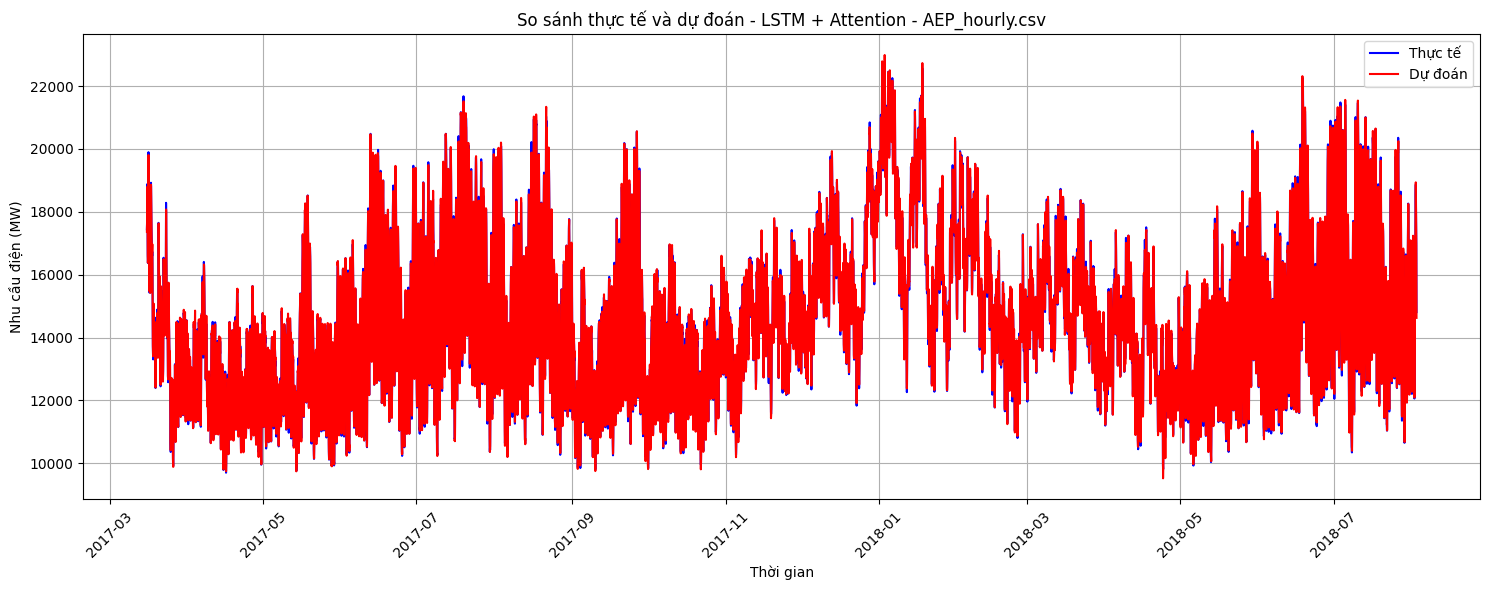

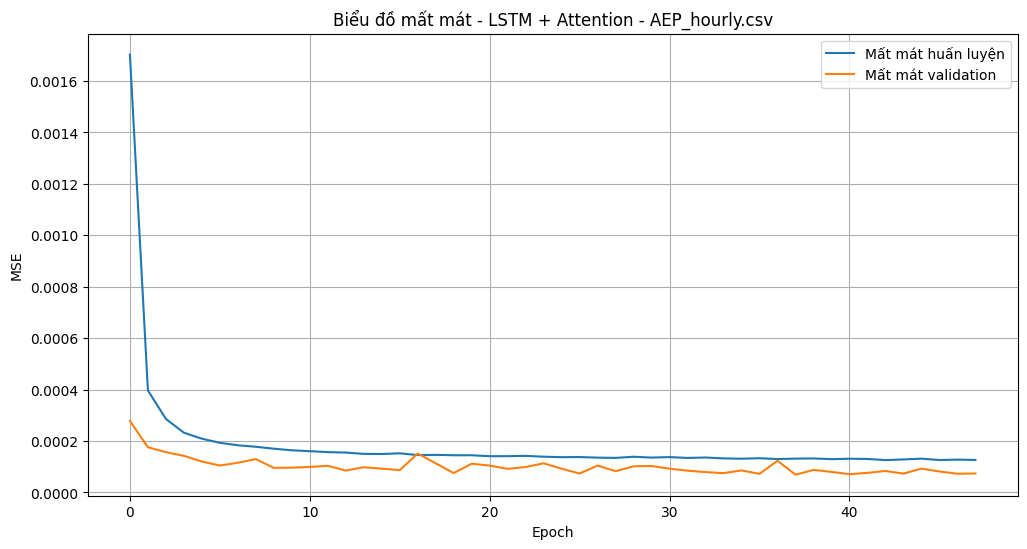

In [12]:
data_files = ['data/AEP_hourly.csv'] 
train_pipeline(data_files, seq_length=24, epochs=50, batch_size=16)

### DAYTON, DOM, DUQ


Processing file: data/DAYTON_hourly.csv
Target column: DAYTON_MW
Kích thước tập train: 97017
Kích thước tập validation: 12127
Kích thước tập test: 12128
Hình dạng X_train: (97017, 24, 12), y_train: (97017,)
Hình dạng X_val: (12127, 24, 12), y_val: (12127,)
Hình dạng X_test: (12128, 24, 12), y_test: (12128,)

Training LSTM + Attention model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 24, 128)   │     72,192 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_6[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 127s 20ms/step - loss: 0.0100 - val_loss: 3.6823e-04
Epoch 2/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 111s 18ms/step - loss: 4.1963e-04 - val_loss: 1.8883e-04
Epoch 3/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 110s 18ms/step - loss: 2.4952e-04 - val_loss: 1.1310e-04
Epoch 4/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 114s 19ms/step - loss: 1.9553e-04 - val_loss: 1.3142e-04
Epoch 5/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 113s 19ms/step - loss: 1.6984e-04 - val_loss: 7.0562e-05
Epoch 6/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 109s 18ms/step - loss: 1.5921e-04 - val_loss: 9.8702e-05
Epoch 7/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 109s 18ms/step - loss: 1.5245e-04 - val_loss: 2.6264e-04
Epoch 8/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 110s 18ms/step - loss: 1.4394e-04 - val_loss: 9.0519e-05
Epoch 9/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 108s 18ms/step - loss: 1.4000e-04 - val_loss: 6.6999e-05
Epoch 10/50
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 109s 18ms/step - loss: 1.3256e-04 - val_loss: 6.1908e-05
Epoch 11/50
6


Kết quả đánh giá LSTM + Attention:
MAE: 17.78 MW
RMSE: 26.68 MW
MAPE: 0.89%


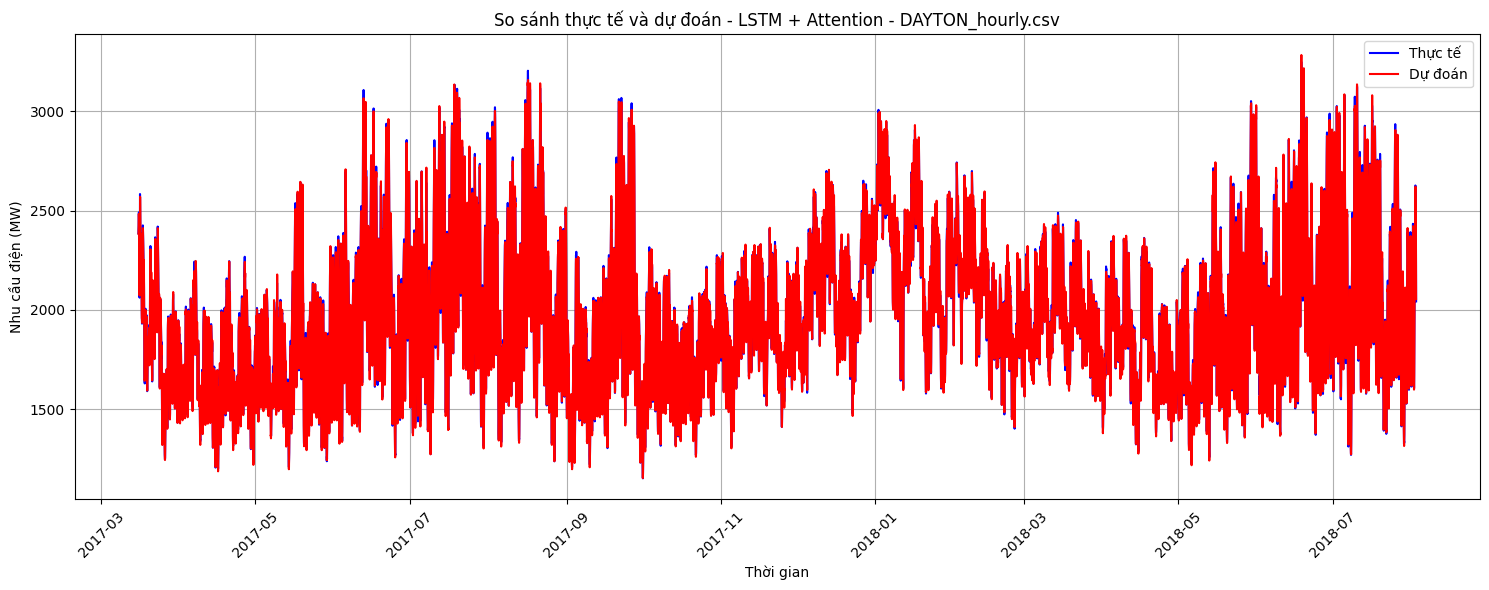

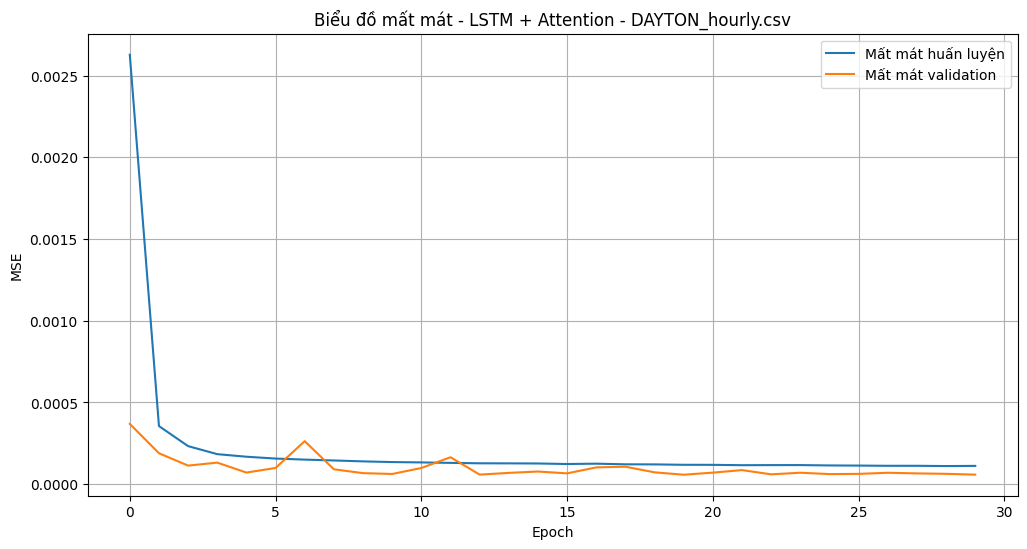


Processing file: data/DOM_hourly.csv
Target column: DOM_MW
Kích thước tập train: 92947
Kích thước tập validation: 11618
Kích thước tập test: 11619
Hình dạng X_train: (92947, 24, 12), y_train: (92947,)
Hình dạng X_val: (11618, 24, 12), y_val: (11618,)
Hình dạng X_test: (11619, 24, 12), y_test: (11619,)

Training LSTM + Attention model...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 24, 128)   │     72,192 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_8[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 123s 21ms/step - loss: 0.0058 - val_loss: 2.0897e-04
Epoch 2/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 945s 163ms/step - loss: 3.6086e-04 - val_loss: 1.2344e-04
Epoch 3/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 7674s 1s/step - loss: 1.7376e-04 - val_loss: 1.5132e-04
Epoch 4/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 1431s 246ms/step - loss: 1.3599e-04 - val_loss: 6.2578e-05
Epoch 5/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 6467s 1s/step - loss: 1.2232e-04 - val_loss: 5.7566e-05
Epoch 6/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 4322s 744ms/step - loss: 1.0780e-04 - val_loss: 6.4937e-05
Epoch 7/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 115s 20ms/step - loss: 1.1034e-04 - val_loss: 4.7106e-05
Epoch 8/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 126s 22ms/step - loss: 9.8916e-05 - val_loss: 5.6769e-05
Epoch 9/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 120s 21ms/step - loss: 9.2465e-05 - val_loss: 5.0622e-05
Epoch 10/50
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 111s 19ms/step - loss: 9.3203e-05 - val_loss: 5.7700e-05
Epoch 11/5


Kết quả đánh giá LSTM + Attention:
MAE: 90.35 MW
RMSE: 128.43 MW
MAPE: 0.79%


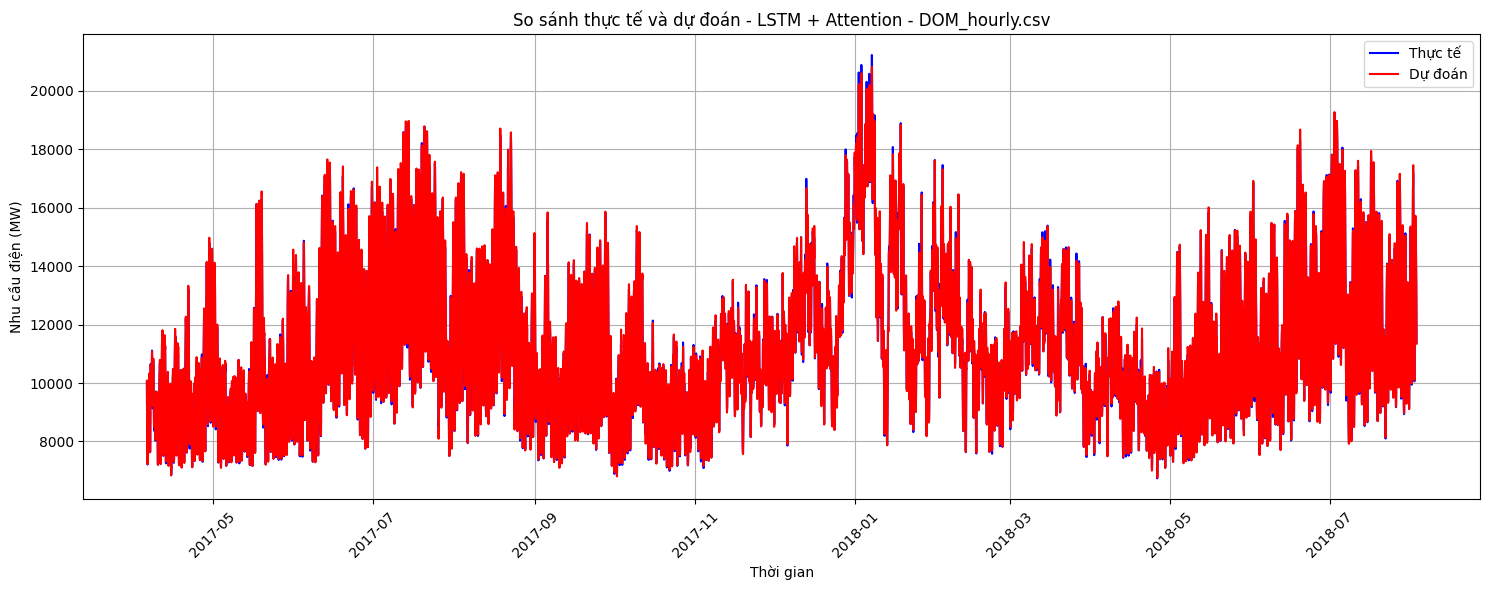

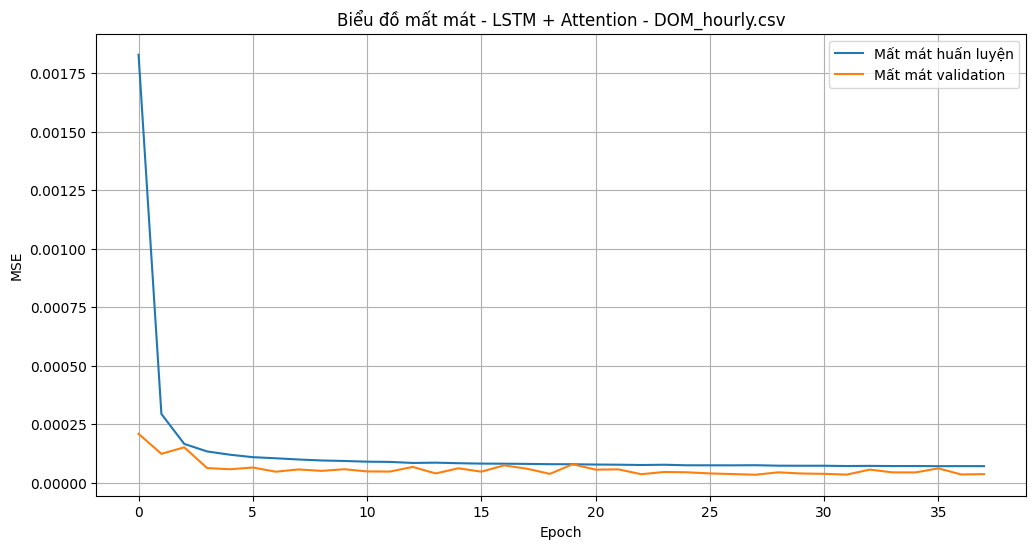


Processing file: data/DUQ_hourly.csv
Target column: DUQ_MW
Kích thước tập train: 95251
Kích thước tập validation: 11906
Kích thước tập test: 11907
Hình dạng X_train: (95251, 24, 12), y_train: (95251,)
Hình dạng X_val: (11906, 24, 12), y_val: (11906,)
Hình dạng X_test: (11907, 24, 12), y_test: (11907,)

Training LSTM + Attention model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 24, 128)   │     72,192 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_10[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ lstm_11[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 114s 19ms/step - loss: 0.0080 - val_loss: 3.6589e-04
Epoch 2/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 110s 18ms/step - loss: 4.5995e-04 - val_loss: 2.1847e-04
Epoch 3/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 114s 19ms/step - loss: 3.3513e-04 - val_loss: 2.3247e-04
Epoch 4/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 115s 19ms/step - loss: 2.8580e-04 - val_loss: 1.5648e-04
Epoch 5/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 114s 19ms/step - loss: 2.5416e-04 - val_loss: 1.3965e-04
Epoch 6/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 114s 19ms/step - loss: 2.4490e-04 - val_loss: 1.1605e-04
Epoch 7/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 117s 20ms/step - loss: 2.3892e-04 - val_loss: 1.5631e-04
Epoch 8/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 113s 19ms/step - loss: 2.3219e-04 - val_loss: 1.4492e-04
Epoch 9/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 117s 20ms/step - loss: 2.2584e-04 - val_loss: 1.2902e-04
Epoch 10/50
5954/5954 ━━━━━━━━━━━━━━━━━━━━ 114s 19ms/step - loss: 2.1354e-04 - val_loss: 1.1892e-04
Epoch 11/50
5


Kết quả đánh giá LSTM + Attention:
MAE: 15.31 MW
RMSE: 20.52 MW
MAPE: 0.98%


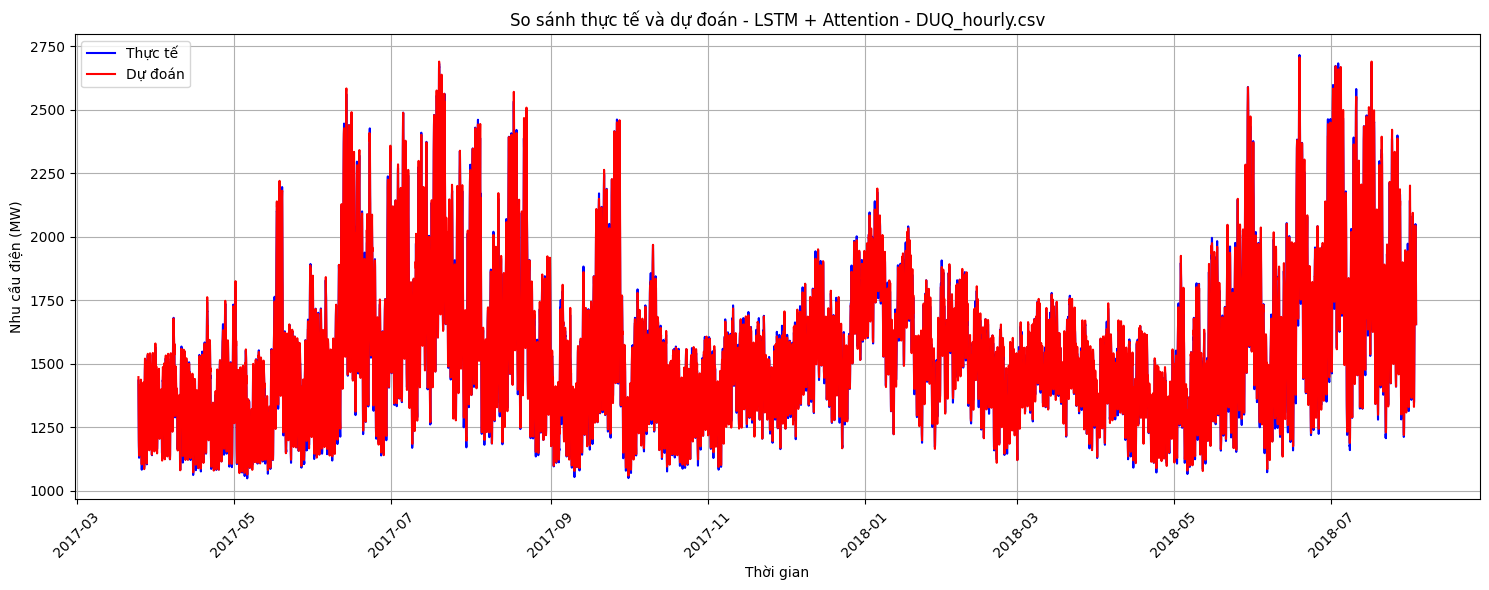

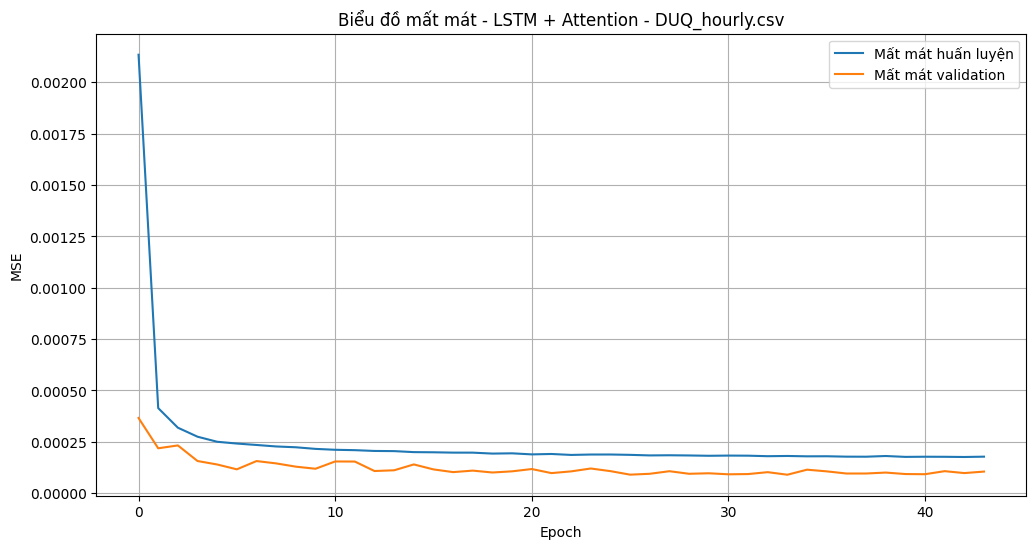

In [13]:
data_files = ['data/DAYTON_hourly.csv', 'data/DOM_hourly.csv', 'data/DUQ_hourly.csv'] 
train_pipeline(data_files, seq_length=24, epochs=50, batch_size=16)


Processing file: data/COMED_hourly.csv
Target column: COMED_MW
Kích thước tập train: 53184
Kích thước tập validation: 6648
Kích thước tập test: 6648
Hình dạng X_train: (53184, 24, 12), y_train: (53184,)
Hình dạng X_val: (6648, 24, 12), y_val: (6648,)
Hình dạng X_test: (6648, 24, 12), y_test: (6648,)

Training LSTM + Attention model...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 24, 128)   │     72,192 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_12[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ lstm_13[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         65 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 62s 18ms/step - loss: 0.0116 - val_loss: 2.7694e-04
Epoch 2/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 5.2665e-04 - val_loss: 1.6699e-04
Epoch 3/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 60s 18ms/step - loss: 2.9455e-04 - val_loss: 1.0846e-04
Epoch 4/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 2.1815e-04 - val_loss: 1.6598e-04
Epoch 5/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - loss: 1.8164e-04 - val_loss: 1.0736e-04
Epoch 6/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 63s 19ms/step - loss: 1.6208e-04 - val_loss: 1.1326e-04
Epoch 7/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 1.4631e-04 - val_loss: 6.0124e-05
Epoch 8/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 1.4046e-04 - val_loss: 6.6763e-05
Epoch 9/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - loss: 1.3269e-04 - val_loss: 6.0322e-05
Epoch 10/50
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - loss: 1.2058e-04 - val_loss: 7.6032e-05
Epoch 11/50
3324/3324 ━


Kết quả đánh giá LSTM + Attention:
MAE: 68.90 MW
RMSE: 93.33 MW
MAPE: 0.60%


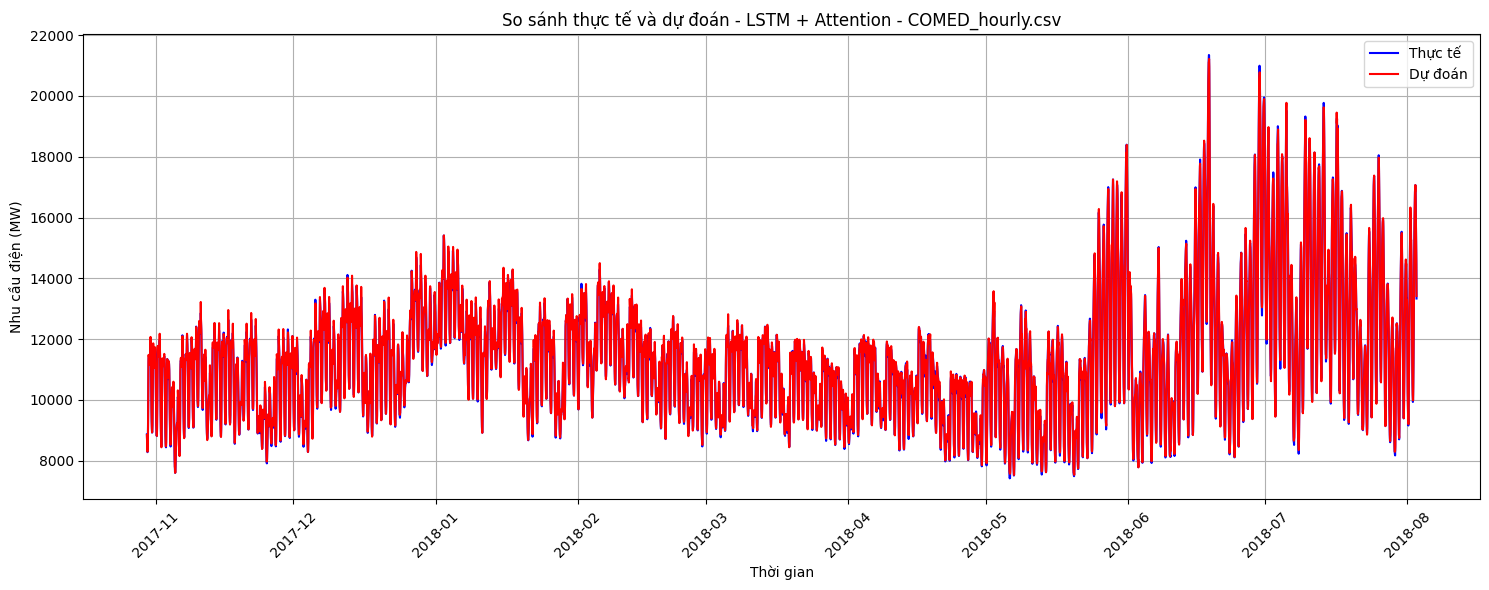

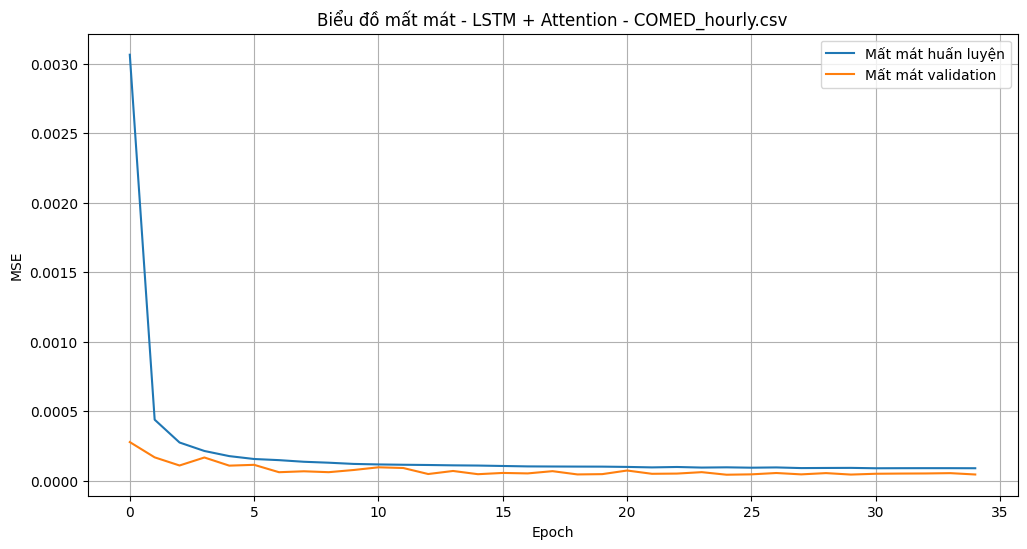


Processing file: data/DEOK_hourly.csv
Target column: DEOK_MW
Kích thước tập train: 46176
Kích thước tập validation: 5772
Kích thước tập test: 5772
Hình dạng X_train: (46176, 24, 12), y_train: (46176,)
Hình dạng X_val: (5772, 24, 12), y_val: (5772,)
Hình dạng X_test: (5772, 24, 12), y_test: (5772,)

Training LSTM + Attention model...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 24, 128)   │     72,192 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_14[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ lstm_15[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - loss: 0.0168 - val_loss: 0.0014
Epoch 2/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 8.9132e-04 - val_loss: 1.8261e-04
Epoch 3/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 4.5846e-04 - val_loss: 2.1509e-04
Epoch 4/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 3.0622e-04 - val_loss: 1.3093e-04
Epoch 5/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 2.2774e-04 - val_loss: 1.3279e-04
Epoch 6/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 1.9178e-04 - val_loss: 1.1900e-04
Epoch 7/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 1.8593e-04 - val_loss: 1.1347e-04
Epoch 8/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - loss: 1.6838e-04 - val_loss: 1.2171e-04
Epoch 9/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 1.5958e-04 - val_loss: 9.6279e-05
Epoch 10/50
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 1.5213e-04 - val_loss: 1.1874e-04
Epoch 11/50
2886/2886 ━━━━━


Kết quả đánh giá LSTM + Attention:
MAE: 33.09 MW
RMSE: 65.29 MW
MAPE: 1.13%


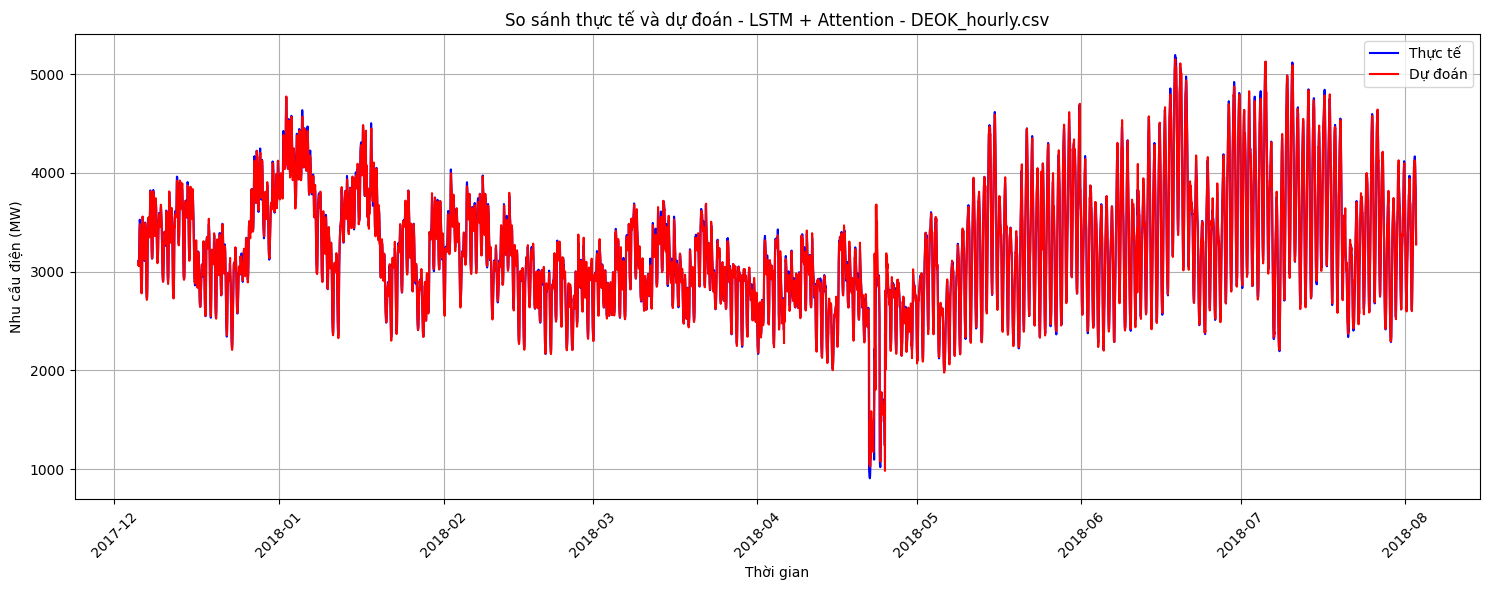

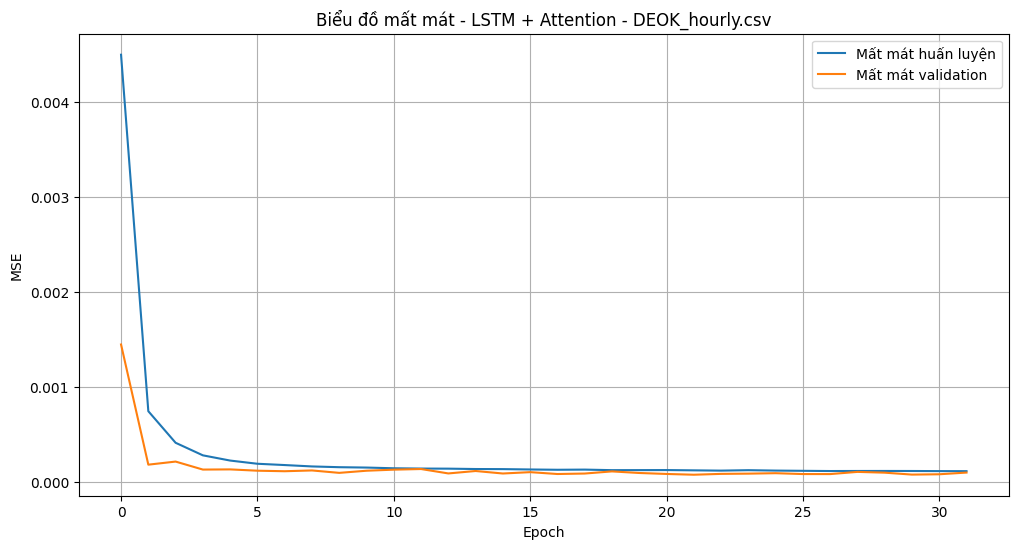


Processing file: data/EKPC_hourly.csv
Target column: EKPC_MW
Kích thước tập train: 36249
Kích thước tập validation: 4531
Kích thước tập test: 4532
Hình dạng X_train: (36249, 24, 12), y_train: (36249,)
Hình dạng X_val: (4531, 24, 12), y_val: (4531,)
Hình dạng X_test: (4532, 24, 12), y_test: (4532,)

Training LSTM + Attention model...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 24, 128)   │     72,192 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_16[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ lstm_17[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 0.0133 - val_loss: 0.0012
Epoch 2/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 8.6588e-04 - val_loss: 0.0010
Epoch 3/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - loss: 5.1909e-04 - val_loss: 2.8707e-04
Epoch 4/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - loss: 4.0010e-04 - val_loss: 3.2558e-04
Epoch 5/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 3.5711e-04 - val_loss: 2.1107e-04
Epoch 6/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - loss: 3.2350e-04 - val_loss: 2.3516e-04
Epoch 7/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 2.9138e-04 - val_loss: 2.7452e-04
Epoch 8/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 2.8472e-04 - val_loss: 2.1027e-04
Epoch 9/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 2.6673e-04 - val_loss: 2.5471e-04
Epoch 10/50
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - loss: 2.5651e-04 - val_loss: 2.3848e-04
Epoch 11/50
2266/2266 ━━━━━━━━━


Kết quả đánh giá LSTM + Attention:
MAE: 27.00 MW
RMSE: 35.58 MW
MAPE: 1.85%


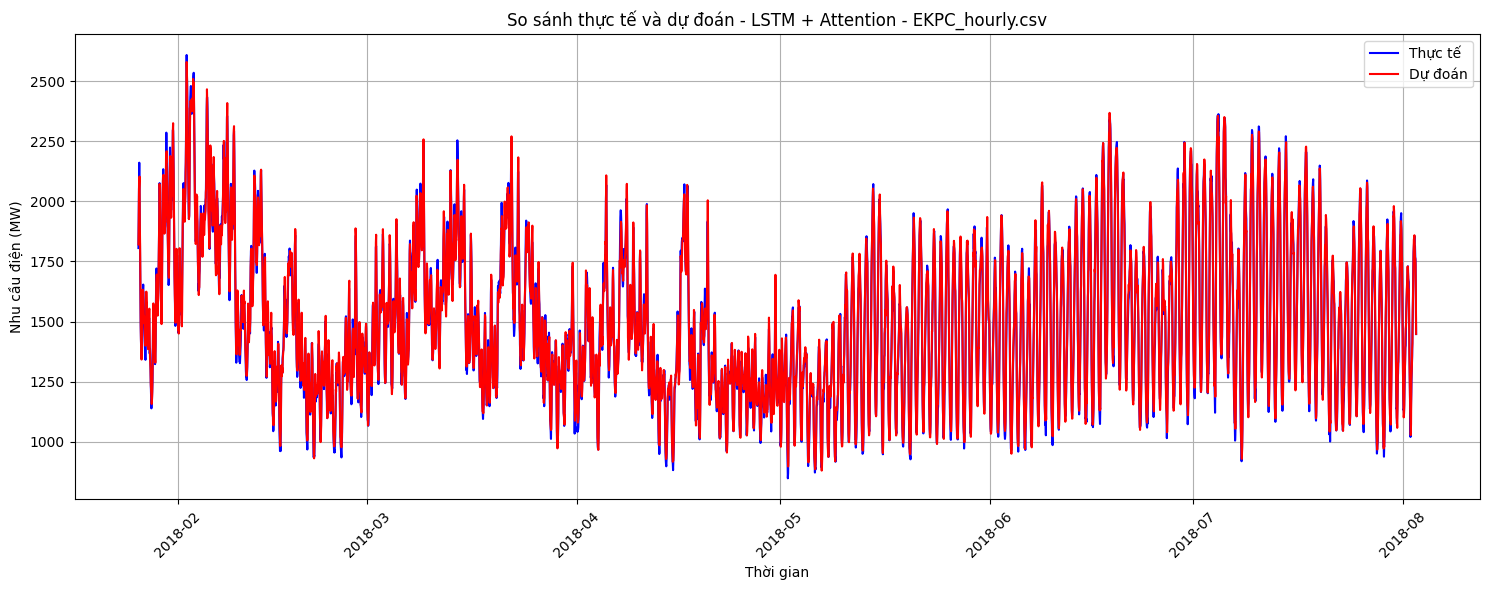

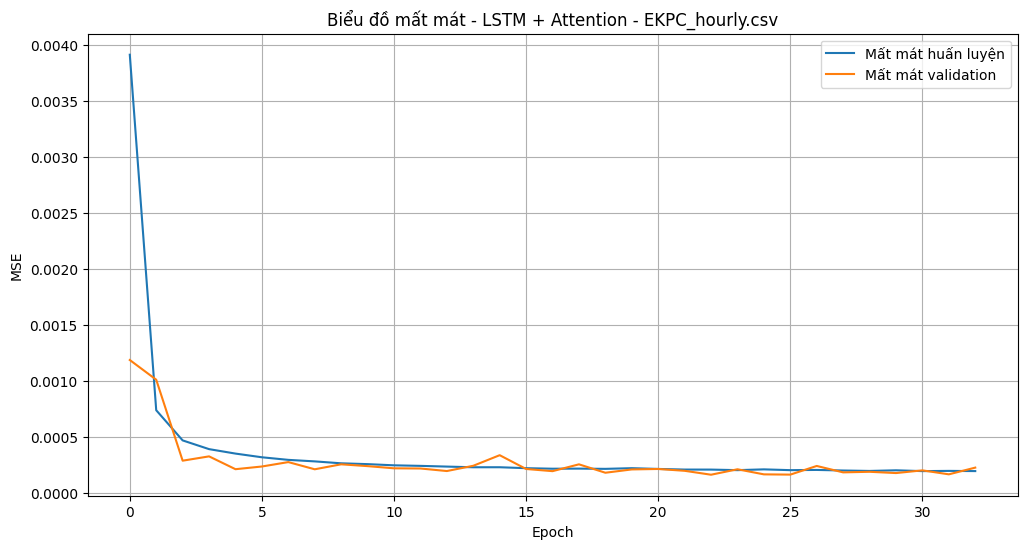


Processing file: data/FE_hourly.csv
Target column: FE_MW
Kích thước tập train: 50284
Kích thước tập validation: 6285
Kích thước tập test: 6287
Hình dạng X_train: (50284, 24, 12), y_train: (50284,)
Hình dạng X_val: (6285, 24, 12), y_val: (6285,)
Hình dạng X_test: (6287, 24, 12), y_test: (6287,)

Training LSTM + Attention model...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 24, 128)   │     72,192 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_18[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ lstm_19[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 62s 19ms/step - loss: 0.0137 - val_loss: 2.2049e-04
Epoch 2/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - loss: 8.2876e-04 - val_loss: 1.6630e-04
Epoch 3/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - loss: 3.9118e-04 - val_loss: 1.0076e-04
Epoch 4/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - loss: 2.0781e-04 - val_loss: 7.7034e-05
Epoch 5/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - loss: 1.4632e-04 - val_loss: 6.5935e-05
Epoch 6/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - loss: 1.2002e-04 - val_loss: 6.0342e-05
Epoch 7/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - loss: 1.0510e-04 - val_loss: 1.1663e-04
Epoch 8/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - loss: 9.7321e-05 - val_loss: 3.9837e-05
Epoch 9/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - loss: 8.7736e-05 - val_loss: 3.5448e-05
Epoch 10/50
3143/3143 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - loss: 8.3332e-05 - val_loss: 4.6938e-05
Epoch 11/50
3143/3143 ━


Kết quả đánh giá LSTM + Attention:
MAE: 57.28 MW
RMSE: 74.39 MW
MAPE: 0.74%


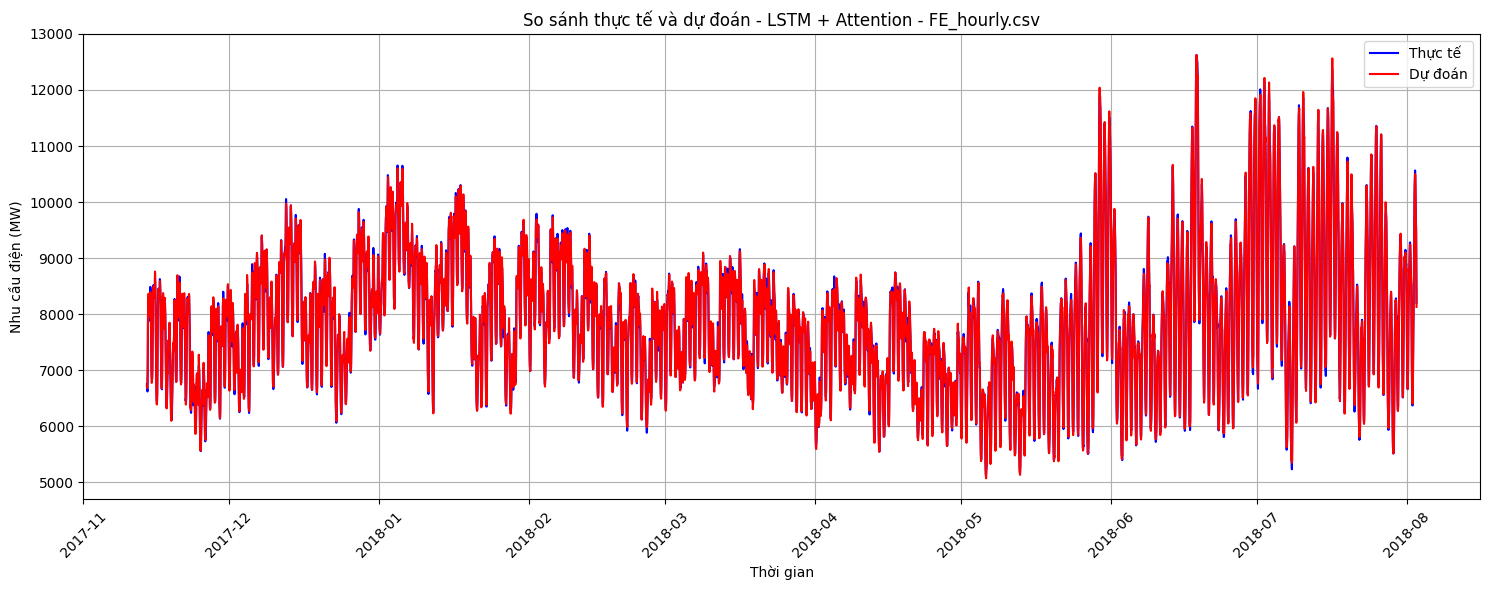

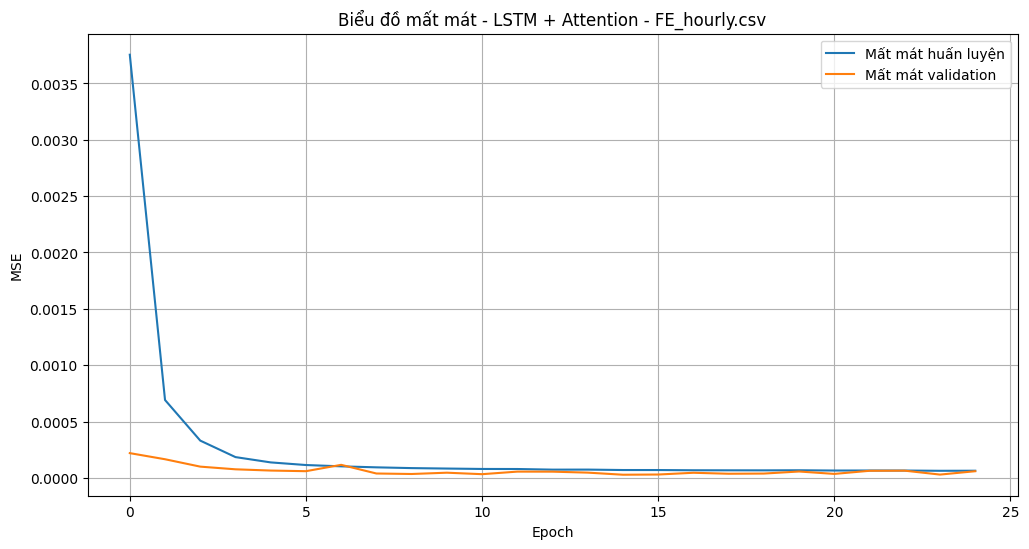


Processing file: data/NI_hourly.csv
Target column: NI_MW
Kích thước tập train: 46752
Kích thước tập validation: 5844
Kích thước tập test: 5844
Hình dạng X_train: (46752, 24, 12), y_train: (46752,)
Hình dạng X_val: (5844, 24, 12), y_val: (5844,)
Hình dạng X_test: (5844, 24, 12), y_test: (5844,)

Training LSTM + Attention model...


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 24, 128)   │     72,192 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_20[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 128)   │     51,628 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 24, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 64)        │          0 │ lstm_21[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         65 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,805 (678.93 KB)

 Trainable params: 173,805 (678.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - loss: 0.0113 - val_loss: 3.6233e-04
Epoch 2/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - loss: 5.5387e-04 - val_loss: 2.3186e-04
Epoch 3/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - loss: 3.2207e-04 - val_loss: 1.8273e-04
Epoch 4/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - loss: 2.3441e-04 - val_loss: 6.3998e-05
Epoch 5/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - loss: 1.9911e-04 - val_loss: 5.7772e-05
Epoch 6/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - loss: 1.6933e-04 - val_loss: 5.0490e-05
Epoch 7/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - loss: 1.5764e-04 - val_loss: 4.8392e-05
Epoch 8/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - loss: 1.3662e-04 - val_loss: 6.4168e-05
Epoch 9/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - loss: 1.3403e-04 - val_loss: 5.8135e-05
Epoch 10/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 1.2441e-04 - val_loss: 4.2265e-05
Epoch 11/50
2922/2922 ━


Kết quả đánh giá LSTM + Attention:
MAE: 90.10 MW
RMSE: 129.48 MW
MAPE: 0.73%


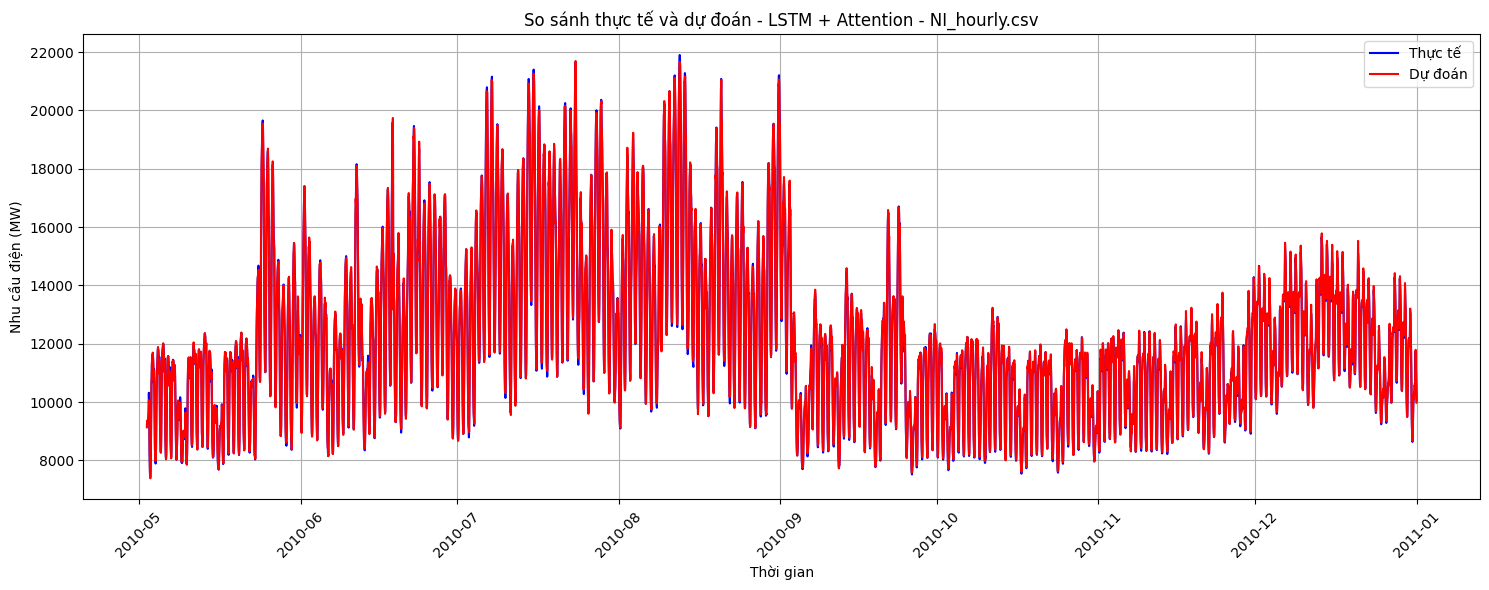

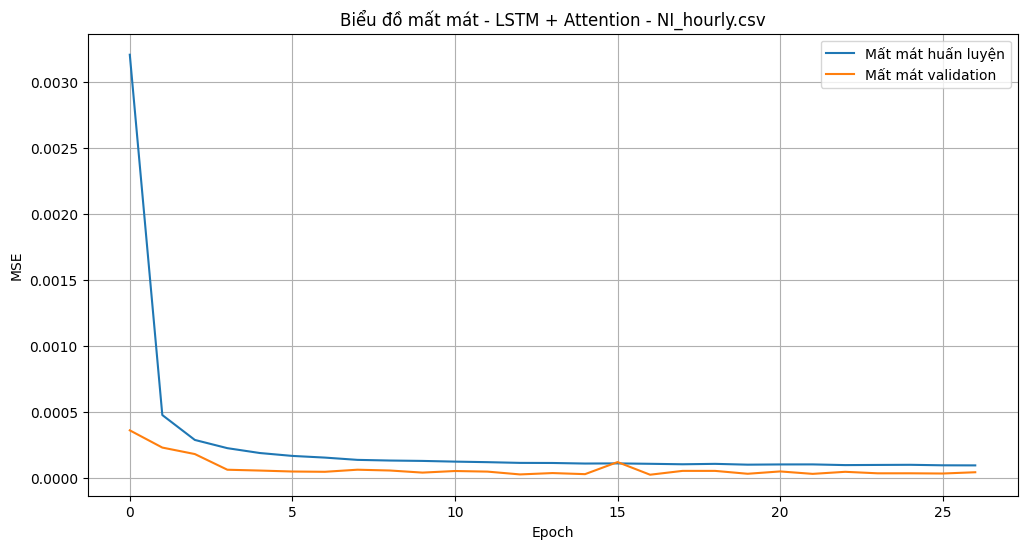

In [14]:
data_files = ['data/COMED_hourly.csv', 'data/DEOK_hourly.csv', 'data/EKPC_hourly.csv', 'data/FE_hourly.csv', 'data/NI_hourly.csv'] 
train_pipeline(data_files, seq_length=24, epochs=50, batch_size=16)